<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Text-Preprocessing" data-toc-modified-id="Text-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Text Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Load-Datasets-and-Quick-Examination" data-toc-modified-id="Load-Datasets-and-Quick-Examination-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Datasets and Quick Examination</a></span></li><li><span><a href="#Check-Missing-Values" data-toc-modified-id="Check-Missing-Values-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check Missing Values</a></span></li><li><span><a href="#Further-Examine-the-Data-and-Create-a-Data-Cleaning-Strategy" data-toc-modified-id="Further-Examine-the-Data-and-Create-a-Data-Cleaning-Strategy-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Further Examine the Data and Create a Data Cleaning Strategy</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Train/Test-Split" data-toc-modified-id="Train/Test-Split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train/Test Split</a></span></li><li><span><a href="#Text-Feature-Extraction" data-toc-modified-id="Text-Feature-Extraction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Text Feature Extraction</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Build-Multi-Label-Classifier" data-toc-modified-id="Build-Multi-Label-Classifier-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Build Multi-Label Classifier</a></span></li></ul></li><li><span><a href="#Advanced-Feature-Engineering:-Word2Vec" data-toc-modified-id="Advanced-Feature-Engineering:-Word2Vec-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Advanced Feature Engineering: Word2Vec</a></span></li></ul></div>

# Text Preprocessing

In [1]:
# necessary libraries
import pandas as pd
import numpy as np
import re

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# for NLP tasks
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk

# for feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# for model building
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

## Load Datasets and Quick Examination

In [2]:
# load training set
df = pd.read_csv('train.csv')

**labeled vs. nonlabeled**
- For training dataset, each row represents a comment with a unique id and 6 binary labels: toxic, sever toxic, obscene, threat, insult, identity hate.
- Each comment can have multiple labels or no label at all, depending on whether it contains toxic messages.

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**imbalance of data**
- The dataset is unbalanced with 90% nonlabeled and 10% labeled. 

In [4]:
# Create a new category indicating non-labeled data
# 1 being qualified, 0 being non-qualified
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['nontoxic'] = 1- df[label_cols].max(axis=1)
df['nontoxic'].value_counts(normalize=True)

1    0.898321
0    0.101679
Name: nontoxic, dtype: float64

In [5]:
df['nontoxic'].value_counts(normalize=True)[0]

0.10167887648758234

In [6]:
non_label_size = df['nontoxic'].value_counts(normalize=True)[1]
label_size = df['nontoxic'].value_counts(normalize=True)[0]

In [7]:
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['text.color'] = 'black'

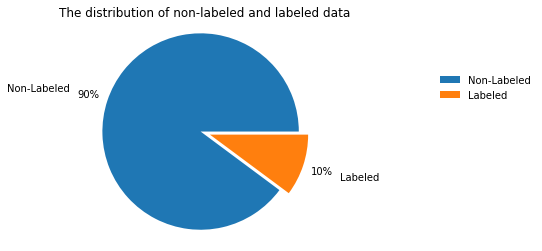

In [8]:
fig, ax = plt.subplots()
percentages = [non_label_size, label_size]
labels = ['Non-Labeled', 
         'Labeled']
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=labels,  
       autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("The distribution of non-labeled and labeled data")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))

## Check Missing Values

**no missing value observed**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
nontoxic         159571 non-null int64
dtypes: int64(7), object(2)
memory usage: 11.0+ MB


## Further Examine the Data and Create a Data Cleaning Strategy

**Examination on non-toxic examples**

In [10]:
print (df['nontoxic'][1])
df['comment_text'][1]

1


"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [11]:
print (df['nontoxic'][3])
df['comment_text'][3]

1


'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [12]:
print (df['nontoxic'][5])
df['comment_text'][5]

1


'"\n\nCongratulations from me as well, use the tools well. \xa0· talk "'

In [13]:
print (df['nontoxic'].iloc[-1])
df['comment_text'].iloc[-1]

1


'"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead of helping rewrite them.   "'

**Examination on toxic examples**

In [14]:
toxic = df.loc[df['nontoxic'] == 0]

In [15]:
toxic = toxic.reset_index(drop=True)

In [16]:
print (toxic.iloc[1, 1])

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


In [17]:
print (toxic.iloc[5, 1])

I'm Sorry 

I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside....with your mom.   76.122.79.82


In [18]:
print (toxic.iloc[-2, 1])

"

Hey listen don't you ever!!!! Delete my edits ever again I'm annoyed because the WWE 2K15 a few of the roster have been confirmed and your stupid ass deletes what I write. just stop!!!! Please STOP!!!! You don't work 2k or WWE games so stop deleting other peoples shit if I get it wrong or others get it wrong let them they will get the hang of it eventually but don't stick your most ass in their and I'm gonna delete the ""please do not insert the roster"" shit how do you not have it if has been confirmed!!!!! God your stupid."


### Context Review:
**What data cleaning task should be applied for this dataset?**
- There are no obvious spelling mistakes observed.
- There are HTML tags and newline characters.
- Contractions, shortened version of words and phrases, are commonly used, since we're dealing with online comments.

**Any extra information?**
- For some comments, the userID and post time of commenter are shown.

**What issues appeared frequently?**
- Complains about comments or edits being erased
- Topics related to WWII, religious etc.

**Any interesting user behaviors?**
- Toxic keywords are often typed in UPPER CASE with special characters to enhance commenters' anger.
- Toxic keywords are often used as Nouns or Verbs.


In [19]:
# Remove HTML tags
from bs4 import BeautifulSoup
def remove_html(text):
    return BeautifulSoup(text, "html.parser").text

In [20]:
# Expand contractions
# Leverage the contractions module, contributed by Dipanjan Sarkar
from contractions import CONTRACTION_MAP
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [21]:
# remove new line characters
def remove_newline(text):
    return text.replace('\n',' ')

In [22]:
# remove special characters, such as escape characters and punctuations
def remove_special_chars(text, remove_digit = False):
    if remove_digit:
        return  re.sub(r"[^a-zA-Z ]"," ",text)
    else:
        return re.sub(r"[^\w\s]"," ",text)

In [23]:
# remove extra whitespaces
def remove_extra_spaces(text):
    return " ".join(text.split())

In [24]:
# clean text function
def clean_corpus(corpus, html_stripping = True, contractions_fix = True, 
                newline_removal = True, special_chars_removal= True,
                extra_spaces_removal = True):
    # remove HTML tags
    if html_stripping:
        doc = remove_html(corpus)
    # expand contractions
    if contractions_fix:
        doc = expand_contractions(doc)
    # remove new line
    if newline_removal:
        doc = remove_newline(doc)
    # remove special characters
    if special_chars_removal:
        doc = remove_special_chars(doc, remove_digit = False)
    # remove extra white spaces
    if extra_spaces_removal:
        doc = remove_extra_spaces(doc)
    return doc

In [25]:
df['clean_comment'] = df['comment_text'].apply(clean_corpus)

/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "http://en.wikipedia.org/wiki/Wikipedia:ELYES" looks like a URL. Beautiful Soup is not an HTTP client

In [26]:
# calculate how many words are all capitals
def all_caps(text):
    return (sum(1 for t in text.split() if t.isupper()))
df['num_allcaps'] = df['comment_text'].apply(all_caps)

In [27]:
# # lemmatize words
# def lemmatizer(text):
#     doc = nlp(text)
#     lemma_list = []
#     for token in doc:
#         if token.lemma_ == "-PRON-":
#             lemma_list.append(token.text)
#         else: 
#             lemma_list.append(token.lemma_)
#     return ' '.join(lemma_list)

In [28]:
# remove stopwords
from nltk import word_tokenize
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english')) 
def remove_stopword(text):
    result = [t for t in word_tokenize(text.lower()) if t not in stopwords]
    return ' '.join(result)

In [29]:
# normalize the corpus 
def normalize_corpus(corpus, stopword_removal = True):
    if stopword_removal:
        doc = remove_stopword(corpus)
    return doc

In [30]:
df['clean_comment'] = df['clean_comment'].apply(normalize_corpus)

In [31]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,nontoxic,clean_comment,num_allcaps
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,explanation edits made username hardcore metal...,2
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,daww matches background colour seemingly stuck...,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,hey man really trying edit war guy constantly ...,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,make real suggestions improvement wondered sec...,5
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,sir hero chance remember page,0


# Exploratory Data Analysis

In [32]:
sns.set_style("white")

**What’s the distribution of each label against each other?**

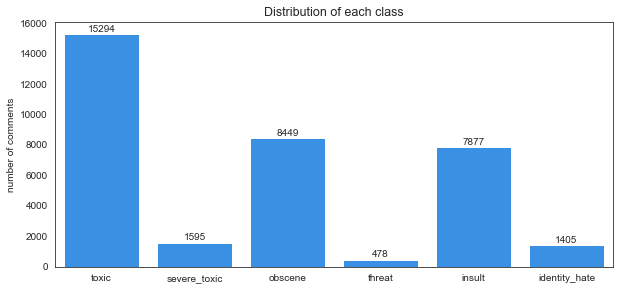

In [33]:
# plot bar charts to show the occurrence number of each label class
plt.figure(figsize = (10,4.5))
class_data = df.iloc[:, 2:8]
ax = sns.barplot(list(class_data.columns), class_data.sum(), color = 'dodgerblue')
plt.title("Distribution of each class", fontsize = 12.5)
plt.ylabel("number of comments")
rects = ax.patches
total = class_data.sum()
for rect, total in zip(rects, total):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, total, ha='center', va='bottom')

- Observations: The number of toxic data in each class are above 30, so we don't need to worry about under-sampling issue.

**What’s the distribution of the positive against negative in each label category?**

In [34]:
totals = class_data.count()
positives = [i/j*100 for i, j in zip(class_data.sum(), totals)]
non_label = class_data.count() - class_data.sum()
nagatives = [i/j*100 for i, j in zip(non_label, totals)]

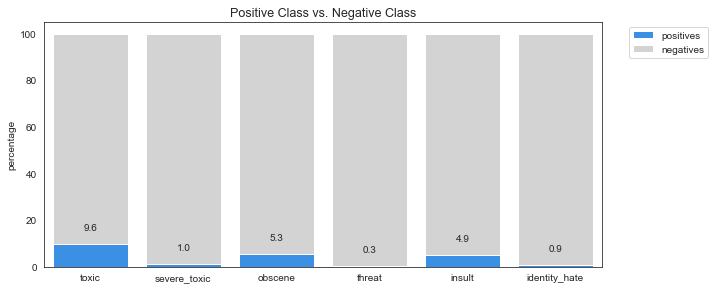

In [35]:
# Plot 100% stacked bar chart to show the imbalance between positive and negative instances
plt.figure(figsize = (10,4.5))
ax1 = sns.barplot(list(class_data.columns), positives, label ='positives', color = 'dodgerblue')
ax2 = sns.barplot(list(class_data.columns),nagatives, bottom= positives, label = 'negatives',  color = 'lightgray')
plt.legend(bbox_to_anchor = (1.2, 1),loc='upper right')
plt.title("Positive Class vs. Negative Class", fontsize = 12.5)
plt.ylabel("percentage")
#adding the text labels
rects = ax1.patches
labels = [round(positive,1) for positive in positives]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

- Observations: "Toxic" class have the most positive data, while "threat" having the least. Based on the distribution, we can make an assumption that the prediction performance of toxic class might be the best and that of threat might be worst.

**What's the co-occurrence rate of the labels? (How do they occur together?)**

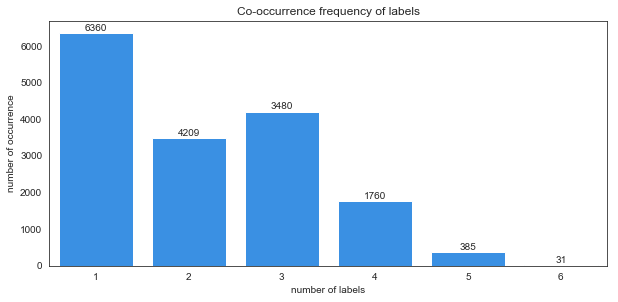

In [36]:
# count the co-occurene frequency of the labels
df['colabeling'] = class_data.sum(axis=1)
colabeling = df['colabeling'].value_counts()
plt.figure(figsize = (10,4.5))
# ignore the ones without any labels
ax = sns.barplot(colabeling.index[1:], colabeling.values[1:], color = 'dodgerblue')
plt.title('Co-occurrence frequency of labels')
plt.xlabel('number of labels')
plt.ylabel('number of occurrence')
# adding the text labels on chart
rects = ax.patches
labels = colabeling.values[1:]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

**What words are most mentioned in each class?**

In [37]:
# prepare comment of each class for creating wordcloud image
toxic = " ".join(comment for comment in df.loc[df['toxic'] == 1, 'clean_comment'])
severe_toxic =  " ".join(comment for comment in df.loc[df['severe_toxic'] == 1, 'clean_comment'])
obscene = " ".join(comment for comment in df.loc[df['obscene'] == 1, 'clean_comment'])
threat = " ".join(comment for comment in df.loc[df['threat'] == 1, 'clean_comment'])
insult = " ".join(comment for comment in df.loc[df['insult'] == 1, 'clean_comment'])
identity_hate = " ".join(comment for comment in df.loc[df['identity_hate'] == 1, 'clean_comment'])

In [38]:
toxic_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(toxic)
severe_toxic_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(severe_toxic)
obscene_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(obscene)
threat_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(threat)
insult_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(insult)
identity_hate_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(identity_hate)

(<matplotlib.axes._subplots.AxesSubplot at 0x1a3270f5c0>,
 (-0.5, 399.5, 199.5, -0.5),
 Text(0.5, 1.0, 'identity_hate'))

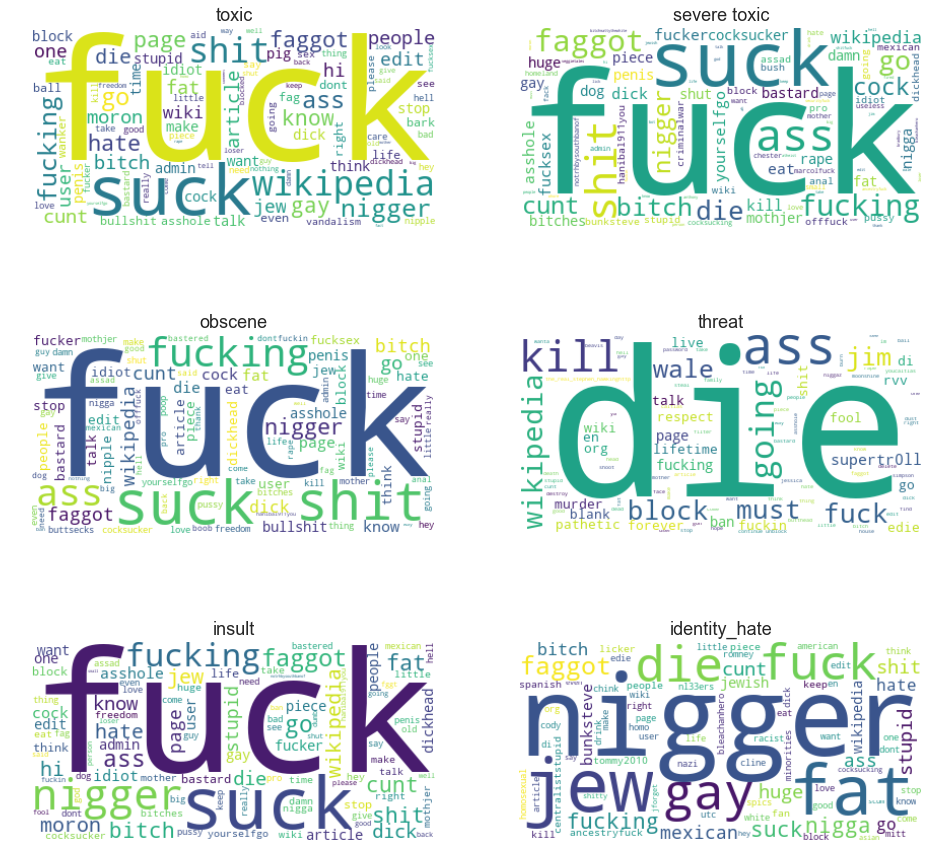

In [39]:
# plot wordcloud image for 6 class
fig=plt.figure(figsize=(16, 16))
plt.subplot(3,2,1), plt.imshow(toxic_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('toxic', fontsize=18)
plt.subplot(3,2,2), plt.imshow(severe_toxic_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('severe toxic', fontsize=18)
plt.subplot(3,2,3), plt.imshow(obscene_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('obscene', fontsize=18)
plt.subplot(3,2,4), plt.imshow(threat_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('threat', fontsize=18)
plt.subplot(3,2,5), plt.imshow(insult_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('insult', fontsize=18)
plt.subplot(3,2,6), plt.imshow(identity_hate_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('identity_hate', fontsize=18)

**How to separate the 6 groups based on dictionary definition**
- toxic: "Very harmful or unpleasant in a pervasive or insidious way", "extremely harsh, malicious, or harmful"
- obscene: "containing or being language regarded as taboo in polite usage", "connected with sex in a way that most people find offensive", "(of the portrayal or description of sexual matters) offensive or disgusting by accepted standards of morality and decency"
- threat: "an expression of intention to inflict evil, injury, or damage", "a statement in which you tell somebody that you will punish or harm them, especially if they do not do what you want"
- insult:"to affect offensively or damagingly", "A disrespectful or scornfully abusive remark or act"
- identity hate: "abusive or threatening speech or writing that expresses prejudice against a particular group, especially on the basis of race, religion, or sexual orientation"


**Initial Findings From WordCloud**
- Since it is a multi-class dataset, which means that, one comment might get more than one labels, keywords such as "fuck" and "suck" are commonly seen across different groups.
- Though the keywords seem to be similar among groups at first glance, "obscene" class is highly associated with sex-related words, "threat" is related to physical-abuse words, "identity hate" is associated with race and gender identity.

# Train/Test Split
- Do train/test split before vectorization to simulate the real world situation in which unseen words happen and should be dropped. Testing set carries the simulation role, that is, carrying words that are unseen in the training. Text in the testing set should not be included in the copus vectorization.

In [122]:
# split the data into training and test
train, test = train_test_split(df, random_state = 0, test_size=0.2, shuffle=True)

In [123]:
X_train = train['clean_comment']
X_test = test['clean_comment']

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Text Feature Extraction
- Text content has to be converted into numerical feature vectors before feeding to machine learning algorithms, which only accept numerical input.
- `Bag-of-Words` and `TF-IDF` are common text representation that treat occurrence frequency of individual token as a feature.

**Limitation** : `Bag-of-Words` and `TF-IDF` ignore the semantic relationship between words because they don't consider the oder.

### Bag-of-Word Representation
- Bag-of-Word (BOW) counts how many times a word appears in a document. It transforms the corpus of documents into a big matrix of token counts. Each row is a document and each column is the occurrence frequency per token.
- Words that don't appear in the corpus will not be represented.

In [42]:
# # use BOW to tokenize and count the word occurrences of a mini corpus
# mini_corpus = df['clean_comment'].sample(n = 1, random_state = 0)
# print (mini_corpus)
# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(mini_corpus)
# # BOW matrix
# X.toarray()

### TF-IDF Term Weighting¶
- TF-IDF (Term Frequency - Inverse Document Frequency) add weights to words according to their relevant importance. The purpose is to increase the weights of unique words, which should be more representative than repetitive words such as "the" and "a" ect.
- TF (similar to BOW) calculates the occurrence frequency of a word in a single document, and IDF measures how often a word appears in all documents. 

In [43]:
# initialize a vectorizer
vectorizer = TfidfVectorizer()
# transform the training dataset
train_text = vectorizer.fit_transform(X_train)

**IDF value tells corpus-specific stopwords**
- IDF value helps to scale down frequent words with less information, and highlight rare words which appear less frequent but are more representative of a document. IDF value of individual word is fixed across the corpus and can be extracted with _idf attribute. Words with low IDF value are viewed as corpus-specific stopwords.

In [44]:
feature_name = np.array(vectorizer.get_feature_names())
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(feature_name[sorted_by_idf][:30]))

Features with lowest idf:
['article' 'page' 'talk' 'wikipedia' 'would' 'please' 'like' 'one' 'see'
 'also' 'think' 'know' 'edit' 'time' 'people' 'articles' 'thanks' 'may'
 'get' 'make' 'even' 'good' 'use' 'well' 'could' 'want' 'way' 'thank'
 'need' 'first']


- Since the corpus is built from wikipedia comments, it is understandable why "article", "page", "talk", and "wikipedia" carry less values.

**TFIDF value tells words with larger influence on models**
- Tfidf value of same word changes across documents, since it is decided not only by the idf value but also its frequency count in that document. To inspect the overall insights, it is better to get the average tfidf value per word and examine the ones with the highest/lowest value.

In [45]:
# take the average of all rows in each column
tfidf_mean = train_text.mean(axis=0)

In [46]:
tfidf_mean.shape

(1, 170204)

In [47]:
# map every average tfidf value to the term it represents
tfidf_mean_series = pd.Series(np.ravel(tfidf_mean), index = feature_name  )

In [48]:
# words with highest tfidf value in average
tfidf_mean_series.nlargest(20)

article      0.019298
talk         0.018821
page         0.018437
wikipedia    0.016537
please       0.014895
would        0.013344
like         0.011413
one          0.010778
thanks       0.010513
edit         0.009875
see          0.009639
know         0.009439
think        0.009329
articles     0.007939
also         0.007908
people       0.007499
user         0.007422
get          0.007318
time         0.007268
use          0.007229
dtype: float64

- Top words with overall highest tfidf value overlap with words with least idf value. It is different that what I initially expected: using high tfidf words to identify toxic-related key words. The result is probably because the dataset is unbalanced with majority data being nontoxic. Words with higher tfidf values are said to have larger influence on the model, but the model prediction result cannot be decided by any single word. The probability of a comment being classified to which label is decided by the combination of weights computed by each words in that comment.

In [49]:
# words with lowest tfidf value in average
tfidf_mean_series.nsmallest(20)

nipp                                                                                                           1.297593e-08
aidsai                                                                                                         1.541586e-08
dienew                                                                                                         1.944975e-08
mahonerz                                                                                                       2.327072e-08
mahy                                                                                                           2.327072e-08
alllllllllllllllllllllllllllllll                                                                               3.052128e-08
blck                                                                                                           3.052128e-08
fukerssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss    3.052128e-08
retrn   

- Smaller tfidf value means that the frequency of a word frequency is very low. Thus, words with least tfidf value are probably just noise.

# Modelling

### Define Problem
**Multi-label classification problem instead of Multi-class problem** 
- Multi-label classification:  Each comment can be assigned to more than one labels. It is expressed with label binary indicator array.
- Multi-class classification: There are more than two kinds of labels but each sample can only have one and only one label. 

### Decide Metrics

Only with evaluation of suitable metrics can a model’s performance be trustworthy. Thinking though the nature of the dataset and the stakeholders’ interests about the prediction paves the way for selecting appropriate metrics and further judging a model good or bad without bias.

**What’s the nature of Wikipedia toxic comment dataset?**
- The dataset is unbalanced because the instances of non-toxic (Negative) are much more than toxic (Positive) for each class.  `Accuracy`, in this case, is not a suitable metrics. Takes “threat class” as an example. The instances of threat and non-threat are 478 and 143346. A non-skill model that predicts every comment as non-threat can guess right almost every time and achieve 0.997 accuracy, yet is incapable of predicting which is threat and which is not. 

**What’s the possible outcome and cost when misclassification happen?**
- Imagine two scenarios: First, if our system incorrectly identifies a neutral comment as toxic (False Positive), and Wikipedia believing the prediction decides to delete the comment and even block the user account . The consequence is costly, because the user who doesn’t do anything wrong might get irritated and refuses to contribute to Wikipedia forever.
- Another is if our system incorrectly identifies a toxic comment as normal (False Negative), and Wikipedia believing the prediction takes no action. The toxic message is shown online until someone finds its inappropriate and reports the system. The cost of misclassification is low. 
- Pondering the possible outcome and cost of misclassification, the penalty of False Positive should be higher than False Negative in our case. 

**Which metrics are more suitable considering the dataset being unbalanced and the cost of False Positive is higher?**

`ROC AUC`: 
- ROC measure the model’s ability to distinguish Positive and Negative class, because it considers True Positive (what we want) and False Positive (what we want to reduce). And AUC summarizes the performance into single number, making it easier to compare between models. It doesn’t hold the assumption of the class distribution, thus it is generally good for dealing with unbalanced dataset. ROC AUC is also the metric used in Kaggle competition.
- *How to interpret ROC AUC score: It means on average how often a model makes a right prediction. If AUC score is 0.8, it means that given a new sample, the model is able to guess correctly on average the 80% of times.*

`Precision-Recall`, `F1-score`: 
- Precision and recall both focus on positive class and ignore True Negatives, which is the major class in toxic project. They are insensitive to the issue of data imbalance, and so does F1, the combination of precision and recall. Since we care more about False Positive than False Negative, we should go for methods with higher precision and be okay with slightly lower recall.

In summary, we'll adopt Precision, Recall, F1 score and ROC AUC as the evaluation metrics and we'll look for models with high ROC AUC and F1 score. In case of a tie, models with higher precision at the expense of slightly low recall are preferred. 

### Decide Solutions
- Models that are good at handling classification problems such as logitic regression, naive bayes, decision tree and random forest are used.
- The baseline model is dummy classifier.

## Build Multi-Label Classifier

### Baseline Model: Dummy Classifier with Bag-Of-Word Algorithm
Here, I use Logistic Regression with bigrams and tfidf extracting text features as baseline models.

In [50]:
# evaluation metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [51]:
labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [52]:
# dummy classifier for baseline model
from sklearn.dummy import DummyClassifier
dummy_model = Pipeline([('bow', CountVectorizer(ngram_range = (1, 1))), 
                            ('clf', OneVsRestClassifier(DummyClassifier(strategy="most_frequent"), n_jobs=1)),
            ])

auc = []
f1 = []
precision = []
recall = []

for label in labels:
    # train the model using X_train & y
    dummy_model.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = dummy_model.predict(X_test)
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
    precision.append(precision_score(test[label], pred_y_test))
    recall.append(recall_score(test[label], pred_y_test))
    
print('average ROC AUC:', np.mean(auc))
print('average f1 score:', np.mean(f1))
print('average precison score:', np.mean(precision))
print('average recall score:', np.mean(recall))

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F

average ROC AUC: 0.5
average f1 score: 0.0
average precison score: 0.0
average recall score: 0.0


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
# dummy regressor for baseline model
from sklearn.dummy import DummyClassifier
dummy_model = Pipeline([('bow', CountVectorizer(ngram_range = (1, 1))), 
                            ('clf', OneVsRestClassifier(DummyClassifier(strategy="stratified"), n_jobs=1)),
            ])

auc = []
f1 = []
precision = []
recall = []

for label in labels:
    # train the model using X_train & y
    dummy_model.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = dummy_model.predict(X_test)
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
    precision.append(precision_score(test[label], pred_y_test))
    recall.append(recall_score(test[label], pred_y_test))
    
print('average ROC AUC:', np.mean(auc))
print('average f1 score:', np.mean(f1))
print('average precison score:', np.mean(precision))
print('average recall score:', np.mean(recall))

average ROC AUC: 0.49974169452371653
average f1 score: 0.036935478874864015
average precison score: 0.036540518998382614
average recall score: 0.037371720405252634


### Models without Tuning

In [54]:
# cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [55]:
# build a reusable fundtion to apply cross-validation to select the 2 better performing models
def cross_val(pipeline, scoring_metrics, X, y, labels, cv = 3):
    """cross validate a model wrapped with transformer in a pipeline with specified scoring metrics,
    and return the socre of each class in a DataFrame"""
    results = {}
    # iterate through 6 lables
    for label in labels:
        scores = cross_validate(pipeline, X, y[label], cv = cv, scoring = scoring_metrics)
        # iterate through metrics
        for metric in scoring_metrics:
            if metric in results.keys():
                 # return an array with 3 test scores
                results[metric].append(np.mean(scores['test_{}'.format(metric)])) 
            else:
                results[metric] = [np.mean(scores['test_{}'.format(metric)])]
    return pd.DataFrame(results, index = [labels])

**Logistic Regression with BOW model**

In [56]:
# apply sklearn pipeline to build logistic regression model 
# vectorize text using bag-of-bigrams representation
# use OneVsRest strategy

lr_bow = Pipeline([('bow', CountVectorizer(ngram_range = (1, 2))), 
                            ('clf', OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter = 1000), n_jobs=1)),
            ])
lr_bow_crossval = cross_val(lr_bow, ['accuracy','roc_auc','f1', 'precision', 'recall'],X_train, train, labels, cv = 3)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [57]:
print ('mean accuracy score: {}'.format(lr_bow_crossval['accuracy'].mean()))
print ('mean ROC AUC score: {}'.format(lr_bow_crossval['roc_auc'].mean()))
print ('mean f1 score {}'.format(lr_bow_crossval['f1'].mean()))
print ('mean precision score {}'.format(lr_bow_crossval['precision'].mean()))
print ('mean recall score {}'.format(lr_bow_crossval['recall'].mean()))

lr_bow_crossval

mean accuracy score: 0.980463118830483
mean ROC AUC score: 0.954337595250788
mean f1 score 0.5106023957239884
mean precision score 0.6471062609592584
mean recall score 0.42631110510213094


,accuracy,roc_auc,f1,precision,recall
toxic,0.956336,0.951960,0.735826,0.871541,0.636758
severe_toxic,0.989981,0.953618,0.355225,0.490341,0.278831
obscene,0.978199,0.969059,0.766735,0.882864,0.677679
threat,0.996514,0.949577,0.259498,0.367740,0.201550
insult,0.970656,0.958048,0.644641,0.798585,0.540826
identity_hate,0.991093,0.943763,0.301689,0.471566,0.222222


Extremely high accuracy:
- The overall accuracy score and individual accuracy for each label are very high. It shows how accuracy sufferes from unbalanced data. For each class, the majority of cases are negative, so when model predicts them to be negative, it naturally results in high accuracy. To be more precise, *threat* has the fewest positive data among all and gets the highest accuracy (0.99), while *toxic* has much more positive data and gets the lowest accuracy (0.95).   

Generally good ROC AUC:
- Each class all performs well in ROC AUC. Though it is the primary metric, it is worth noticing that ROC AUC is an approximation of aggregating a model performance when the threshold is set to be any possible value. It sometimes might be not well informed. So, that's why we also need to look into f1, precision, and recall.

Huge difference in f1, precision, recall:
- Contrary to the accuracy score, *threat* has the fewest positive data among all and gets the lowest precision (0.36), while *toxic* has much more positive data and gets the highest (0.87). 

In [ ]:
# check the confusion metrix: call out for toxic and threat class
# high accuracy: majority class (more data) can be easy to predict
# precision/recall: 

**Logistic Regression with tf-idf vectorization**

In [58]:
# TF-IDF
lr_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter = 1000), n_jobs=1)),
            ])
lr_tfidf_crossval = cross_val(lr_tfidf, ['roc_auc','f1', 'precision', 'recall'],X_train, train, labels, cv = 3)


In [59]:
print ('mean ROC AUC score: {}'.format(lr_tfidf_crossval['roc_auc'].mean()))
print ('mean f1 score {}'.format(lr_tfidf_crossval['f1'].mean()))
print ('mean precision score {}'.format(lr_tfidf_crossval['precision'].mean()))
print ('mean recall score {}'.format(lr_tfidf_crossval['recall'].mean()))

lr_tfidf_crossval

mean ROC AUC score: 0.9767972157831886
mean f1 score 0.4549599126194817
mean precision score 0.760540302599245
mean recall score 0.34665659513829605


,roc_auc,f1,precision,recall
toxic,0.967142,0.695333,0.933268,0.554088
severe_toxic,0.985295,0.341417,0.572679,0.243286
obscene,0.983968,0.723586,0.922300,0.595468
threat,0.975125,0.163301,0.669017,0.093023
insult,0.975407,0.598886,0.824387,0.470316
identity_hate,0.973845,0.207236,0.641590,0.123758


**Comments on Logistic Regression Models:** 
- Above I built two vanilla logistic regression models respecitvely with Bag-of-Word model and tf-idf vectorizer. No hyper parameters are being tuned, except that solver is set to be lbfgs in order to quiet the warning. 
- When comparing the two approaches feature extraction, our priority metric is roc auc score, with which tf-idf vectorization performs better(0.97) than BoW model(0.95). Though tf-idf gives slightly lower f1 score(0.45) than BoW model(0.51), its precision is much better. Combining these, I will choose tf-idf to extract text features for all other models we're going to build.

**Naive Bayes**

In [60]:
NB = Pipeline([('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),])
NB_crossval = cross_val(NB, ['roc_auc','f1', 'precision', 'recall'],X_train, train, labels, cv = 3)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F

In [61]:
print ('NB average ROC AUC: {}'.format(NB_crossval['roc_auc'].mean()))
print ('NB average f1: {}'.format(NB_crossval['f1'].mean()))

NB_crossval

NB average ROC AUC: 0.8474637381084338
NB average f1: 0.08963759936518949


,roc_auc,f1,precision,recall
toxic,0.877626,0.274232,0.995411,0.159026
severe_toxic,0.877557,0.000000,0.000000,0.000000
obscene,0.879773,0.190400,0.991796,0.105318
threat,0.770168,0.000000,0.000000,0.000000
insult,0.870708,0.073193,0.967088,0.038039
identity_hate,0.808952,0.000000,0.000000,0.000000


**Comment on Naive Bayes:**
- Multinomial Naive Bayes expects integer inputs, so it might work better with CountVectorizer than TfidfVectorizer which comes with weighted inputs.
- Question: Why its f1 score is super low, and for some class it predicts 0 True Positive Cases?

In [60]:
# doesn't predict any 0 positive cases, it faces challenges of unbalanced data
# limitation of NB

**Decision Tree**

In [62]:
from sklearn.tree import DecisionTreeClassifier
dt = Pipeline([('tfidf', TfidfVectorizer()), ('clf', DecisionTreeClassifier()),])
dt_crossval = cross_val(dt, ['roc_auc','f1', 'precision', 'recall'],X_train, train, labels, cv = 3)

In [63]:
print ('mean ROC AUC score: {}'.format(dt_crossval['roc_auc'].mean()))
print ('mean f1 score {}'.format(dt_crossval['f1'].mean()))
dt_crossval

mean ROC AUC score: 0.7313009805582587
mean f1 score 0.4874362752192509


,roc_auc,f1,precision,recall
toxic,0.831053,0.692070,0.696967,0.687280
severe_toxic,0.626584,0.279007,0.316484,0.249605
obscene,0.874198,0.761612,0.767274,0.756036
threat,0.600029,0.232892,0.293029,0.196382
insult,0.796203,0.609071,0.611202,0.607512
identity_hate,0.659738,0.349965,0.387031,0.319783


In [117]:
print ('mean precision score {}'.format(dt_crossval['precision'].mean()))
print ('mean recall score {}'.format(dt_crossval['recall'].mean()))

mean precision score 0.5119979911064069
mean recall score 0.4694331388677058


**Ensemble Classifier: Random Forest**

In [64]:
from sklearn.ensemble import RandomForestClassifier
rf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier()),])
rf_crossval = cross_val(rf, ['roc_auc','f1', 'precision', 'recall'],X_train, train, labels, cv = 3)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

In [65]:
print ('mean ROC AUC score: {}'.format(rf_crossval['roc_auc'].mean()))
print ('mean f1 score {}'.format(rf_crossval['f1'].mean()))
rf_crossval

mean ROC AUC score: 0.8681400648834986
mean f1 score 0.372264831631679


,roc_auc,f1,precision,recall
toxic,0.929993,0.669607,0.893220,0.535637
severe_toxic,0.860387,0.110982,0.490929,0.063191
obscene,0.964365,0.724866,0.890274,0.611615
threat,0.719063,0.085276,0.549784,0.046512
insult,0.937033,0.544294,0.786545,0.416203
identity_hate,0.797998,0.098564,0.557555,0.054201


In [116]:
print ('mean precision score {}'.format(rf_crossval['precision'].mean()))
print ('mean recall score {}'.format(rf_crossval['recall'].mean()))

mean precision score 0.6947178348710907
mean recall score 0.2878930613057926


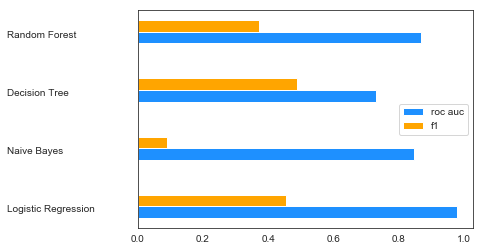

In [66]:
# model selection using charts
classifiers = [lr_tfidf_crossval,NB_crossval,dt_crossval,rf_crossval]
indices = np.arange(len(classifiers))
roc_auc = [classifier['roc_auc'].mean() for classifier in classifiers]
plt.barh(indices, roc_auc, .2, label="roc auc", color='dodgerblue')

f1 = [classifier['f1'].mean() for classifier in classifiers]
plt.barh(indices +.2, f1, .2, label="f1", color='orange')

plt.yticks(())
plt.legend(loc='best')

classifiers_name = ['Logistic Regression', 'Naive Bayes','Decision Tree', 'Random Forest']
for i, c in zip(indices, classifiers_name):
    plt.text(-.4,i, c)

### Tuning Top-Performed Models: Logistic Regression
- We select the two top-performned models to tune their parameters and tfidf vecotrizer. Decision tree has the highest ROC AUC score. (explanation open to add)
- SVM model ranks second among models, yet its ROC AUC score(0.72) is close to Logistic Regression (0.68). It is natual to for us to choose the simpler model, in this case Logistic Regression, which achieves similar performance.

#### Performance Benchmark with Baseline Model
- Before start tuning any model, we use the logistic regression with BOW model to get a baseline test score for benchmarking tuned models.

In [67]:
# get baseline score from vanilla logistic regression with BOW model
auc = []
f1 = []
precision = []
recall = []

for label in labels:
    # train the model using X_train & y
    lr_bow.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = lr_bow.predict(X_test)
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
    precision.append(precision_score(test[label], pred_y_test))
    recall.append(recall_score(test[label], pred_y_test))
    
print('average ROC AUC:', np.mean(auc))
print('average f1 score:', np.mean(f1))
print('average precison score:', np.mean(precision))
print('average recall score:', np.mean(recall))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


average ROC AUC: 0.7205175191663264
average f1 score: 0.5246817592453357
average precison score: 0.6430066985318501
average recall score: 0.44620420816016404


#### Trail-and-Error Tuning Process

In [126]:
# Logistic regression (without tuning) on training set
lr_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter = 1000), n_jobs=1)),
            ])
auc = []
f1 = []
precision = []
recall = []

for label in labels:
    # train the model using X_train & y
    lr_tfidf.fit(X_train, train[label])
    # training score
    pred_y_train = lr_tfidf.predict(X_train)
    auc.append(roc_auc_score(train[label], pred_y_train))
    f1.append(f1_score(train[label], pred_y_train))
    precision.append(precision_score(train[label], pred_y_train))
    recall.append(recall_score(train[label], pred_y_train))
    
print('average ROC AUC:', np.mean(auc))
print('average f1 score:', np.mean(f1))
print('average precison score:', np.mean(precision))
print('average recall score:', np.mean(recall))

average ROC AUC: 0.6938734340530299
average f1 score: 0.5028916735229095
average precison score: 0.8129916055052311
average recall score: 0.3897748867633153


In [127]:
# Logistic regression (without tuning) on testing set
auc = []
f1 = []
precision = []
recall = []

for label in labels:
    # train the model using X_train & y
    lr_tfidf.fit(X_train, train[label])
    # training score
    pred_y_test = lr_tfidf.predict(X_test)
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
    precision.append(precision_score(test[label], pred_y_test))
    recall.append(recall_score(test[label], pred_y_test))
    
print('average ROC AUC:', np.mean(auc))
print('average f1 score:', np.mean(f1))
print('average precison score:', np.mean(precision))
print('average recall score:', np.mean(recall))

average ROC AUC: 0.6835835414562642
average f1 score: 0.47690926577004694
average precison score: 0.738031923260121
average recall score: 0.37001984298529633


In [68]:
from sklearn.model_selection import GridSearchCV

In [69]:
# when only tuned logistic regression(C and penalty)
lr_param = {'clf__estimator__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], # control regularization to avoid overfitting or underfitting
            'clf__estimator__penalty': ['l2']} 

lr_grid_search = GridSearchCV(lr_tfidf, param_grid = lr_param, cv=3, scoring='roc_auc')

lr_grid_search.fit(X_train, train[labels])
print ('Best score: %0.3f' % lr_grid_search.best_score_)
print ('Best paramters set:', lr_grid_search.best_params_)

Best score: 0.977
Best paramters set: {'clf__estimator__C': 1, 'clf__estimator__penalty': 'l2'}


In [125]:
# Apply optimized model on training set
lr_optimized = Pipeline([('tfidf', TfidfVectorizer()), 
                        ('clf', OneVsRestClassifier(LogisticRegression(solver = 'lbfgs',max_iter = 1000))),
                         ])
auc = []
f1 = []
precision = []
recall = []

for label in labels:
    # train the model using X_train & y
    lr_optimized.fit(X_train, train[label])
    # training score
    pred_y_train = lr_optimized.predict(X_train)
    auc.append(roc_auc_score(train[label], pred_y_train))
    f1.append(f1_score(train[label], pred_y_train))
    precision.append(precision_score(train[label], pred_y_train))
    recall.append(recall_score(train[label], pred_y_train))
    
print('average ROC AUC:', np.mean(auc))
print('average f1 score:', np.mean(f1))
print('average precison score:', np.mean(precision))
print('average recall score:', np.mean(recall))

average ROC AUC: 0.6938734340530299
average f1 score: 0.5028916735229095
average precison score: 0.8129916055052311
average recall score: 0.3897748867633153


In [70]:
# Apply optimized model on test set

lr_optimized = Pipeline([('tfidf', TfidfVectorizer()), 
                        ('clf', OneVsRestClassifier(LogisticRegression(solver = 'lbfgs', C = 1, penalty = 'l2',max_iter = 1000))),
                         ])
auc = []
f1 = []
precision = []
recall = []

for label in labels:
    # train the model using X_train & y
    lr_optimized.fit(X_train, train[label])
    # testing score
    pred_y_test = lr_optimized.predict(X_test)
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
    precision.append(precision_score(test[label], pred_y_test))
    recall.append(recall_score(test[label], pred_y_test))
    
print('average ROC AUC:', np.mean(auc))
print('average f1 score:', np.mean(f1))
print('average precison score:', np.mean(precision))
print('average recall score:', np.mean(recall))

# tfidf isn't always better
# better precision when putting the model into production

average ROC AUC: 0.6835835414562642
average f1 score: 0.47690926577004694
average precison score: 0.738031923260121
average recall score: 0.37001984298529633


In [71]:
lr_optimized.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
           vocabulary=None)),
  ('clf',
   OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=1000, multi_class='warn',
             n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
             tol=0.0001, verbose=0, warm_start=False),
             n_jobs=None))],
 'tfidf': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='utf-8', input='c

- The best parameters returned are the default value set for logistic regression. 
- Thr problem is that even when the model is tuned, it perfoms worse than our vanilla model.

In [72]:
# with tfidf max_df tuned
lr_param_2 = {'tfidf__max_df': [0.7, 0.8, 0.9],
              #min_df=10
              #max_features=30000, 
            'clf__estimator__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], # control regularization to avoid overfitting or underfitting
            'clf__estimator__penalty': ['l2']} 

lr_grid_search_2 = GridSearchCV(lr_tfidf, param_grid = lr_param_2, cv=3, scoring='roc_auc')

lr_grid_search_2.fit(X_train, train[labels])

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...tate=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tfidf__max_df': [0.7, 0.8, 0.9], 'clf__estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'clf__estimator__penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [73]:
print ('Best score: %0.3f' % lr_grid_search_2.best_score_)
print ('Best paramters set:', lr_grid_search_2.best_params_)

Best score: 0.977
Best paramters set: {'clf__estimator__C': 1, 'clf__estimator__penalty': 'l2', 'tfidf__max_df': 0.7}


In [74]:
# Apply optimized logistic regression on test dataset

lr_optimized_2 = Pipeline([('tfidf', TfidfVectorizer(max_df = 0.7)), 
                        ('clf', OneVsRestClassifier(LogisticRegression(solver = 'lbfgs', C = 1, penalty = 'l2',max_iter = 1000))),
                         ])
auc = []
f1 = []
precision = []
recall = []

for label in labels:
    # train the model using X_train & y
    lr_optimized_2.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = lr_optimized_2.predict(X_test)
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
    precision.append(precision_score(test[label], pred_y_test))
    recall.append(recall_score(test[label], pred_y_test))
    
print('average ROC AUC:', np.mean(auc))
print('average f1 score:', np.mean(f1))
print('average precison score:', np.mean(precision))
print('average recall score:', np.mean(recall))

#words above 0.7 may have no influence

average ROC AUC: 0.6835835414562642
average f1 score: 0.47690926577004694
average precison score: 0.738031923260121
average recall score: 0.37001984298529633


In [91]:
lr_optimized_2.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=0.7, max_features=None, min_df=1,
           ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
           vocabulary=None)),
  ('clf',
   OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=1000, multi_class='warn',
             n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
             tol=0.0001, verbose=0, warm_start=False),
             n_jobs=None))],
 'tfidf': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='utf-8', input='c

In [104]:
# with solver and max df tuned together
from sklearn.model_selection import RandomizedSearchCV
lr_param_3 = {'tfidf__max_df': [0.5, 0.75],
            'tfidf__max_features':[10000, 30000],
            'clf__estimator__C':[0.01, 0.1, 1, 10], # control regularization to avoid overfitting or underfitting
            #'clf__estimator__penalty': ['l1','l2'],
             'clf__estimator__solver': ['lbfgs', 'sag', 'saga']} 

lr_grid_search_3 = RandomizedSearchCV(lr_tfidf, param_distributions = lr_param_3, cv = 2, scoring='roc_auc')

lr_grid_search_3.fit(X_train, train[labels])

print ('Best score: %0.3f' % lr_grid_search_3.best_score_)
print ('Best paramters set:', lr_grid_search_3.best_params_)

Best score: 0.976
Best paramters set: {'tfidf__max_features': 30000, 'tfidf__max_df': 0.5, 'clf__estimator__solver': 'sag', 'clf__estimator__C': 1}


In [105]:
# Apply optimized logistic regression on test dataset

lr_optimized_3 = Pipeline([('tfidf', TfidfVectorizer(max_df = 0.5, max_features = 30000)), 
                        ('clf', OneVsRestClassifier(LogisticRegression(solver = 'lbfgs', C = 1, penalty = 'l2',max_iter = 1000))),
                         ])
auc = []
f1 = []
precision = []
recall = []

for label in labels:
    # train the model using X_train & y
    lr_optimized_3.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = lr_optimized_3.predict(X_test)
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
    precision.append(precision_score(test[label], pred_y_test))
    recall.append(recall_score(test[label], pred_y_test))
    
print('average ROC AUC:', np.mean(auc))
print('average f1 score:', np.mean(f1))
print('average precison score:', np.mean(precision))
print('average recall score:', np.mean(recall))

average ROC AUC: 0.6826110878622625
average f1 score: 0.47304886792566814
average precison score: 0.7302315449107528
average recall score: 0.36812678201390464


In [98]:
lr_optimized_3.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=0.5, max_features=30000, min_df=1,
           ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
           vocabulary=None)),
  ('clf',
   OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=1000, multi_class='warn',
             n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
             tol=0.0001, verbose=0, warm_start=False),
             n_jobs=None))],
 'tfidf': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='utf-8', input='

In [ ]:
# with solver and max df tuned together
from sklearn.model_selection import RandomizedSearchCV
lr_param_3 = {'tfidf__max_df': [0.5, 0.75],
            'tfidf__max_features':[10000, 30000],
            'tfidf__max_features':
            'clf__estimator__C':[0.01, 0.1, 1, 10], # control regularization to avoid overfitting or underfitting
            #'clf__estimator__penalty': ['l1','l2'],
             #'clf__estimator__solver': ['lbfgs', 'sag', 'saga']} 

lr_grid_search_3 = RandomizedSearchCV(lr_tfidf, param_distributions = lr_param_3, cv = 2, scoring='roc_auc')

lr_grid_search_3.fit(X_train, train[labels])

print ('Best score: %0.3f' % lr_grid_search_3.best_score_)
print ('Best paramters set:', lr_grid_search_3.best_params_)

In [ ]:
# the scores are lower than expected, so I want to check if the tuning really works
# and if not, then how to improve from there

#1. what are you comparing to: optimized on test vs vanilla model on cross validation
### vanilla model on test data to get the right expectation ????
#### option1: dummy model

#2. what parameters are set for vanilla model
### defalt -- C:1, penality:l2, solver is set to be lbfgs
### optimzied -- C:1, penality:l2, solver is set to be lbfgs

#### in short, optimized model is the same as the vanialla model


#3. what to do next?
### a. change the parameter values
### b. drop feartures by grid searching for best values for Tfidf: max_df
### c. chi-square test

In [ ]:
# the parameter of untuned logistic regression
lr_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter = 1000), n_jobs=1)),
            ])
lr_tfidf.get_params

In [ ]:
# overfitting
# solution: 1. dropping features: a.based on frequency b.chi-square feature selection

In [69]:
fuck = ['fuck']
lr_optimized.fit(X_train, train['toxic'])
lr_optimized.predict_proba(fuck)[:, 1]

array([0.99999954])

### Examing ROC AUC Curve

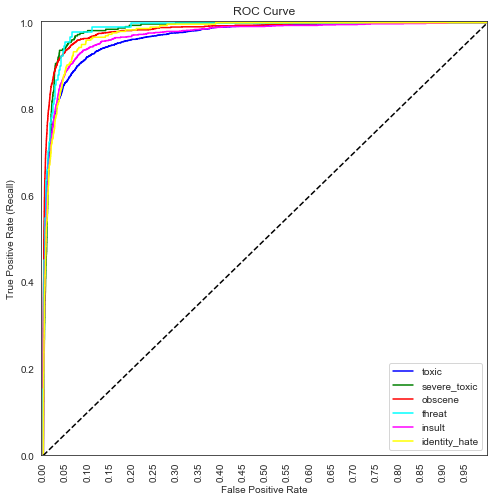

In [76]:
# Plot 6 ROC AUC curves respectively for 6 binary classification problems
from sklearn.metrics import roc_curve
plt.figure(figsize=(8,8))
colors = ["blue", "green", "red", "cyan", "magenta", "yellow"]
i = 0
for label in labels:
    y_prob = lr_optimized.fit(X_train,train[label]).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(test[label],y_prob)
    plt.plot(fpr, tpr, label = label, color = colors[i])
    i += 1
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0,1, 0.05), rotation=90)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc='best')

**Comments on the ROC AUC curve for logistic regression**:
> ROC AUC curve tells how a model is capable of distinguishing between classes. ROC curve shows the trade-off between TPR on y-axis and FPR on x-axis. Top left corner is the sweet spot where TPR is maximized and FPR is minimized. AUC score measures a model's separation ability. It represents the probability that the model ranks a random positive example more highly than a random negative example.

- Above plot shows the good overall performance of the model with each curve close toward the top left corner. The average AUC score for 6 separate binary classifiers is 0.683, **meaning that averagely there is 68% chance that model can distinguish between positive class and negative class.** 
- Among 6 classes, threat and server toxic perform the best while toxic class has more room for improvement.

### Choosing Optimal Threshold

If taking *business context* into consideration when using evaluation metrics, precision and recall are more suitble than ROC AUC.

I decide to take a closer examination on the "toxic" class and choose a threshold that balances precision and recall in a way that makes sense for this business context where the cost of False Positive is higher than that of False Negative.

In [77]:
from sklearn.metrics import confusion_matrix
toxic_pred = lr_optimized.fit(X_train, train['toxic']).predict(X_test)
# auc score
print (roc_auc_score(test['toxic'], toxic_pred))

0.7904191663342557


In [78]:
# confusion matrix when threshold set to be 0.5 by default
print (confusion_matrix(test['toxic'], toxic_pred))
tn, fp, fn, tp = confusion_matrix(test['toxic'], toxic_pred).ravel()
print ('precision: {}'.format(tp / (fp + tp)))

[[28667   147]
 [ 1284  1817]]
precision: 0.925152749490835


In [79]:
# manual check the trade-ff between precision and recall at different threshold value
y_pred_prob = lr_optimized.fit(X_train, train['toxic']).predict_proba(X_test)[:, 1]
threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in threshold_list:
    y_pred_toxic = (y_pred_prob > i)*1
    tn, fp, fn, tp = confusion_matrix(test['toxic'], y_pred_toxic).ravel()
    precision = tp / (fp + tp)
    recall = tp / (fn+ tp)
    print (i, precision, recall)

0.1 0.5507189285010833 0.9016446307642696
0.2 0.7469005140610826 0.7965172524991938
0.3 0.8413298073290517 0.7181554337310545
0.4 0.8876651982378855 0.6497903901967107
0.5 0.925152749490835 0.5859400193485972
0.6 0.9532983070636311 0.526604321186714
0.7 0.9636963696369637 0.4708158658497259
0.8 0.9746268656716418 0.4211544663011932
0.9 0.9897196261682243 0.34150274105127376


**Decision on optimal threshold**:
- The default threshold at 0.5 has already provided good precision score at 0.93. We can be very confident to trust the result when model predicts a sample Positive. The high precision reduces the risk when we take a suspected comment down from the platform, while it is indeed neutral.
- 0.4 gives a good balance between precision and recall. While we don't want to piss off the user due to misalarm, we don't want to miss capturing toxic messages and cause negative impact on user behaviors. Thus, 0.4 is the recommended threshold value.

### Manual Inspecting Misclassification

In [74]:
print (X_test.shape)
print (test['toxic'].shape)
print (y_pred_prob.shape)
print (toxic_pred.shape)

(31915,)
(31915,)
(31915,)
(31915,)


In [75]:
error_df = pd.DataFrame({'test_text':np.array(X_test),'prob':y_pred_prob, 
             'real_class':np.array(test['toxic']), 'pred_class':toxic_pred})

In [76]:
# create a dataframe for manual error examination
error_df.head()

,test_text,prob,real_class,pred_class
0,paraphrased gary complained preferring recent ...,0.013910,0,0
1,blocked revers blocked revers blocked revers b...,0.040183,1,0
2,sorry would like unreservedly retract previous...,0.422637,0,0
3,know exactly like press release use source htt...,0.021492,0,0
4,thank improve wikipedia 2007 dear thanks warm ...,0.015262,0,0


**false alarm**

In [77]:
fp_df = error_df.loc[error_df['pred_class'] > error_df['real_class']].sort_values(by = ['prob'], ascending=True)
fp_df.head()

,test_text,prob,real_class,pred_class
29354,oh see yall jelous cause yall bunch yankees im...,0.501642,0,1
18486,psychological problems advice dude looking ext...,0.502282,0,1
25962,would argue whitemanners seriously disturbed i...,0.502987,0,1
25850,least castro trying liberate cuba us dominatio...,0.503230,0,1
23441,neutral big violation refuses talk without inv...,0.504794,0,1


**miss detection**

In [78]:
fn_df = error_df.loc[error_df['pred_class'] < error_df['real_class']].sort_values(by = ['prob'], ascending=False)
fn_df.head()

,test_text,prob,real_class,pred_class
26323,axeman 10 says vandalize ac dcs page perform s...,0.499804,1,0
158,666 2x holy 333 trinity repent bastard,0.499435,1,0
2289,unblock prick yeah,0.499227,1,0
3466,wtf man every edit made blindly reverted olahu...,0.498281,1,0
17423,hum pig,0.498226,1,0


### Tuning Top-Performed Model: Random Forest

In [ ]:
# Random Forest hyper-parameter tuning

from sklearn.model_selection import RandomizedSearchCV

rf_param = {'clf__n_estimators': [100], # control number of trees
            'clf__max_features' : ['auto', 'log2'],  
            'clf__min_samples_leaf': [1, 10, 30],
             } 

rf_grid_search = GridSearchCV(rf, param_grid = rf_param, cv=3, scoring='roc_auc')

rf_grid_search.fit(X_train, train[labels])
print ('Best score: %0.3f' % rf_grid_search.best_score_)
print ('Best paramters set:', rf_grid_search.best_params_)

In [ ]:
# Using Kaggle notebook, Google collaborator to run
# RUn just few to see how it takes

In [ ]:
# Apply optimized logistic regression on test dataset
rf_optimized = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier()),])
auc = []

for label in labels:
    print('... Processing {}'.format(label))
    # train the model using X_train & y
    rf_optimized.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = rf_optimized.predict(X_test)
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    auc.append(roc_auc_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))

# Advanced Feature Engineering: Word2Vec
**Shortcoming of count-based models**
- Previously, I used count-based models, Bag-of-Words and Tfidf, for feature engineering, which ended with descent result. However, these models fail to capture the contextual relationship among words and often requires large copora due to its nature of high-dimensional sparce vector. 

**The need for wordembeddings: Word2Vec**
- One way to solve the above issue is word embeddings, which can capture the semantic relationship. Here, I'm applying Word2Vec features for the classification task to see if better score can be achieved.

In [80]:
# import gensim
from gensim.models import word2vec

In [81]:
# tokenize the normalized training corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(comment) for comment in X_train]

In [82]:
# build word2vec model
from gensim.models import Word2Vec
w2v = Word2Vec(tokenized_corpus, 
               size = 300, # word vector dimensionality 
               window = 5, # context window size    
               min_count = 10, 
               workers = 4)

In [83]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v.wv.most_similar([search_term], topn=5)]
                  for search_term in ['wikipedia','talk','hate','fuck','suck','shit','kill','gay']}
similar_words

{'wikipedia': ['wiki', 'wikipedias', 'encyclopedia', 'wikis', 'wikpedia'],
 'talk': ['dαlus', 'talkpage', 'disambig', 'dab', 'replies'],
 'hate': ['nl33ers', 'spew', 'monger', 'outraged', 'disgusting'],
 'fuck': ['shut', 'suppressing', 'cunt', 'niggas', 'assclown'],
 'suck': ['lick', 'cock', 'sucker', 'dick', 'sucking'],
 'shit': ['crap', 'worthless', 'fucking', 'asshole', 'garbage'],
 'kill': ['burn', 'shoot', 'raping', 'raped', 'marry'],
 'gay': ['gays', 'bisexual', 'homosexual', 'nambla', 'niggers']}

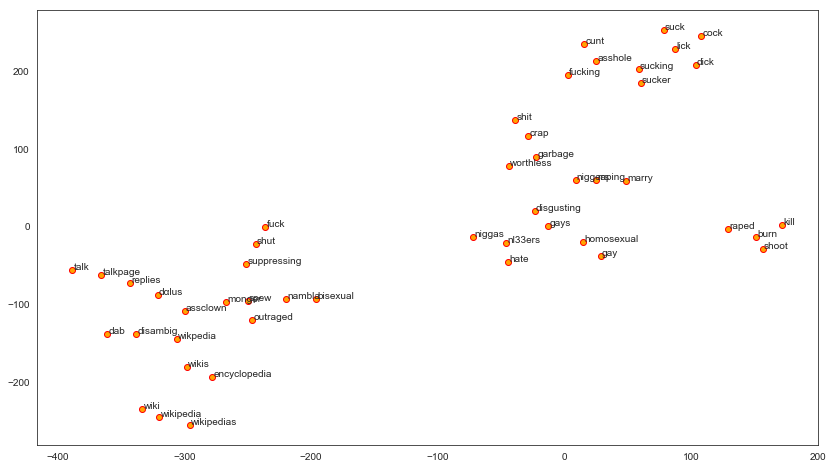

In [84]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Document-level of word embeddings
- Word2Vec model trained on the training text generates a multi-dimensional vector per uniqe word. To apply it to extract feature of each wikipedia comment, we need to produce document-level embeddings. The process ensures that each input (numerical representation of a comment) fitting to the model shares same dimension.
- One way to get document-level embeddings is to average out the Word2Vec of each word in a comment. For example, if we have 3 words in a sentence. We'll need to add up 3 100-dimensional vectors and divide it by 3 to get a final vector, representing the sentence.

In [85]:
# document level of word embedding

In [86]:
def average_vector(sentence, model, vocabulary, vector_dimension):
   
    """add up the vector computed from w2v model of each word from a sentence,
    and divide values by the sentence length to get an average word vector"""
    
    feature_vector = np.zeros(vector_dimension) #initialize an empty matrix with the same size as the vector dimension
    len_sentence = 0 #calculate the length of a sentence
    for word in sentence:
        if word in vocabulary: #in case there are unseen words in the training set
            len_sentence += 1
            feature_vector = np.add(feature_vector, model[word]) #add the vector dimension to the matrix
    
    if len_sentence != 0:
        feature_vector = np.divide(feature_vector, len_sentence)
    
    return feature_vector

In [87]:
def averaged_word_vectorizer(corpus, model, vector_dimension):
    vocabulary = set(model.wv.index2word)
    features = [average_vector(tokenized_sentence, model, vocabulary, vector_dimension)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [88]:
# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v, vector_dimension=300)
#w2v_feature_df = pd.DataFrame(w2v_feature_array)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [90]:
w2v_feature_df = pd.DataFrame(w2v_feature_array)
w2v_feature_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.443437,-0.101974,0.125504,0.118711,0.337243,1.215878,-0.426222,-0.052759,0.116461,0.138789,...,-0.279151,-0.317763,0.012044,0.173221,0.206149,-0.347704,-0.151392,-0.049570,0.406362,-0.140676
1,-0.393184,0.123954,0.366812,0.039203,-0.466144,-0.016190,-0.119087,1.689807,-0.013028,0.718312,...,0.623670,-0.376161,-0.029229,-0.319538,0.277165,-0.114607,-0.253298,0.195857,-0.281959,-0.157292
2,0.105665,-0.217559,0.198102,0.340606,0.104750,0.292860,0.061797,-0.076496,0.009434,-0.076995,...,-0.292251,-0.180081,0.082851,0.045045,0.015376,-0.136268,-0.133932,0.029226,0.120085,-0.208696
3,0.262852,-0.067682,0.184289,0.230270,0.113267,0.089891,-0.201271,0.547134,-0.022248,0.141597,...,-0.138074,-0.183824,-0.042399,0.117593,0.155445,-0.167790,-0.179641,0.020598,0.205607,0.042991
4,0.145500,0.407441,0.262631,0.115843,-0.246494,0.275117,-0.961790,0.842041,-0.590411,0.174369,...,-0.091683,0.501428,-0.538089,0.190013,-0.117074,-0.240208,0.246660,0.207954,0.086796,-0.322175


In [91]:
w2v_feature_df.shape

(127656, 300)

In [92]:
X_train.shape

(127656,)

In [93]:
w2v_feature_array.shape

(127656, 300)

In [94]:
w2v_feature_array

array([[ 0.44343682, -0.10197389,  0.12550378, ..., -0.04957028,
         0.40636246, -0.14067638],
       [-0.39318371,  0.12395355,  0.36681151, ...,  0.19585694,
        -0.28195938, -0.15729241],
       [ 0.10566543, -0.21755895,  0.19810217, ...,  0.02922605,
         0.12008478, -0.20869551],
       ...,
       [ 0.06640216,  0.40260595, -0.08798708, ..., -0.11860191,
        -0.18025072,  0.15909011],
       [ 0.2398616 ,  0.16035948,  0.06451048, ..., -0.06801321,
        -0.1980457 , -0.40176552],
       [ 0.36368297, -0.17984696,  0.06070218, ...,  0.20096245,
        -0.02426234,  0.30574348]])

In [95]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [96]:
# prepare for the test data
wpt = nltk.WordPunctTokenizer()
train_corpus = [wpt.tokenize(comment) for comment in X_test]

In [100]:
w2v_test_array = averaged_word_vectorizer(corpus=train_corpus, model=w2v,
                                             vector_dimension=300)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


### Apply Word2Vect to Machine Learning

In [101]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [102]:
# train the machine learning model: logistic regression, with w2v feature
# Apply optimized logistic regression on test dataset

lr = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs', max_iter = 1000))

auc = []
f1 = []
precision = []
recall = []

for label in labels:
    # train the model using X_train & y
    lr.fit(w2v_feature_array, train[label])
    # compute the testing accuracy
    pred_y_test = lr.predict(w2v_test_array)
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
    precision.append(precision_score(test[label], pred_y_test))
    recall.append(recall_score(test[label], pred_y_test))
    
print('average ROC AUC:', np.mean(auc))
print('average f1 score:', np.mean(f1))
print('average precison score:', np.mean(precision))
print('average recall score:', np.mean(recall))

# sequence of words may not be more important than the frequency
# sequential deep learning mdoel will be better, for the true power of wrod embedding

average ROC AUC: 0.6530186933609875
average f1 score: 0.39617467335660533
average precison score: 0.5889349660475637
average recall score: 0.31155466934005566


In [103]:
# train the machine learning model: logistic regression, with w2v feature
# Apply optimized logistic regression on test dataset

lr = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs', C = 10,max_iter = 1000))

auc = []
f1 = []
precision = []
recall = []

for label in labels:
    # train the model using X_train & y
    lr.fit(w2v_feature_array, train[label])
    # compute the testing accuracy
    pred_y_test = lr.predict(w2v_test_array)
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
    precision.append(precision_score(test[label], pred_y_test))
    recall.append(recall_score(test[label], pred_y_test))
    
print('average ROC AUC:', np.mean(auc))
print('average f1 score:', np.mean(f1))
print('average precison score:', np.mean(precision))
print('average recall score:', np.mean(recall))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


average ROC AUC: 0.6604114648512961
average f1 score: 0.41443788212215615
average precison score: 0.6098307057720894
average recall score: 0.3261863344507403


### Model Interpretability

SHAP has a summary_plot method which shows us the top features impacting model predictions for a batch of examples (in this case 25).

#### Explain the linear model

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [107]:
vectorizer = TfidfVectorizer()
toxic_train = vectorizer.fit_transform(X_train[:500])

In [108]:
toxic_lr = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs', C = 1, penalty = 'l2',max_iter = 1000))

In [109]:
toxic_lr.fit(toxic_train, train['toxic'][:500])

OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [110]:
import shap

In [111]:
explainer = shap.LinearExplainer(toxic_lr, toxic_train, feature_perturbation="interventional")

In [112]:
shap_values = explainer.shap_values(toxic_train)
toxic_train_array = toxic_train.toarray() # we need to pass a dense version for the plotting functions

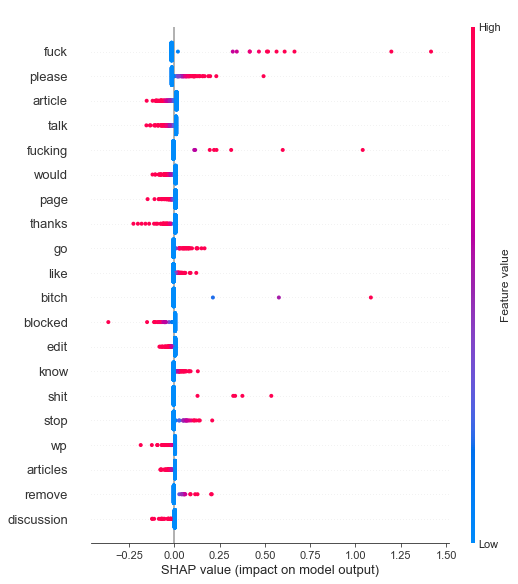

In [113]:
shap.summary_plot(shap_values, toxic_train_array, feature_names=vectorizer.get_feature_names())
# higher SHAP means higher confidence to classify to toxic

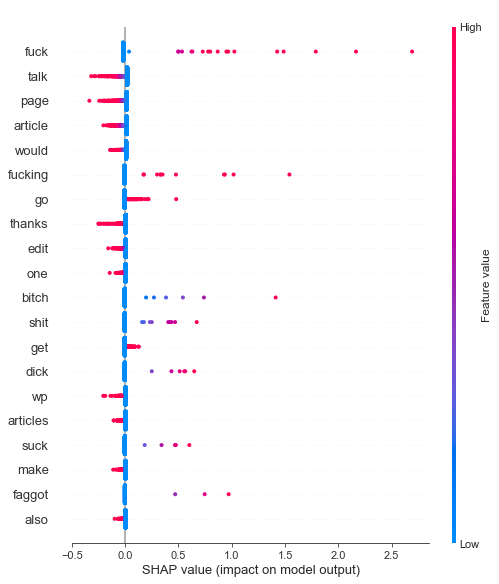

In [114]:
# obscene
vectorizer = TfidfVectorizer()
obscene_train = vectorizer.fit_transform(X_train[:1000])

obscene_lr = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs',max_iter = 1000))
obscene_lr.fit(obscene_train, train['obscene'][:1000])
explainer = shap.LinearExplainer(obscene_lr, obscene_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(obscene_train)
obscene_train_array = obscene_train.toarray() # we need to pass a dense version for the plotting functions
shap.summary_plot(shap_values, obscene_train_array, feature_names=vectorizer.get_feature_names())

# imbalance and overlapping

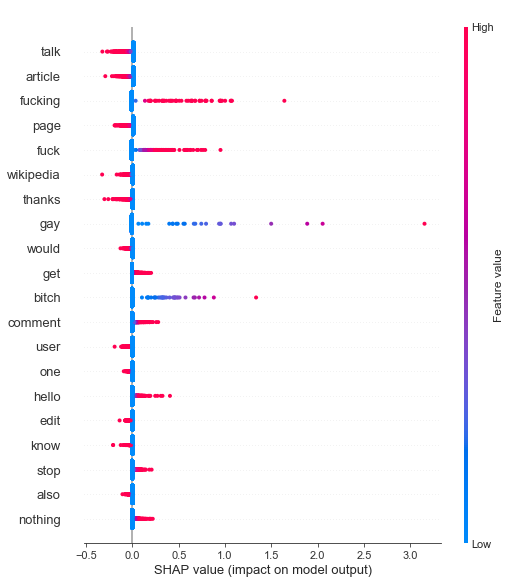

In [115]:
# identity hate
vectorizer = TfidfVectorizer()
identity_hate_train = vectorizer.fit_transform(X_train[:5000])
identity_hate_lr = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs',max_iter = 1000))
identity_hate_lr.fit(identity_hate_train, train['identity_hate'][:5000])
explainer = shap.LinearExplainer(identity_hate_lr, identity_hate_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(identity_hate_train)
identity_hate_train_array = identity_hate_train.toarray() # we need to pass a dense version for the plotting functions
shap.summary_plot(shap_values, identity_hate_train_array, feature_names=vectorizer.get_feature_names())

In [ ]:
#num_explanations = 25
#shap_vals = explainer.shap_values(body_test[:num_explanations])